<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png" style="padding-right:10px;width:140px;float:left;padding10:3px;padding-top:10px;"></td>
<h1 style="white-space: nowrap"> Project Milestone 3</h1>
<h3 style="white-space: nowrap;margin:22px">  Applied Data Analysis (CS-401) </h3>
<hr style="clear:both">
<p style="font-size:1em; margin:2px; text-align:justify">
    <b>Description: </b>This Colab notebook is aimed at investigating the QuoteBank database provided in the course of Applied Data Analysis by Professor Robert West. The data consists of quotes from newspapers dated from 2015 to 2020 included. The goal of our project is to generate a timeline using the bertopic analysis of the quotes and then proceed to a sentiment analysis for some specific topics such that we can observe how certain events can affect the general opinion towards certains topic in a positive or negative way.
</p>


<p style="font-size:0.95em; margin:0px"><b>Authors: </b> 
    <a href="mailto:lucas.brunschwig@epfl.ch"> Lucas Brunschwig</a>, 
    <a href="mailto:ioannis.mavrothalassitis@epfl.ch"> Ioannis Mavrothalassitis</a>, 
    <a href="mailto:axelle.piguet@epfl.ch"> Axelle Piguet</a>, 
    <a href="mailto:ester.simkova@epfl.ch"> Ester Simkova</a>

</p>
<p style="font-size:0.95em; margin:0px"><b>Data: </b> </p>
<ul> 
   <li> Raw data: <a href="https://zenodo.org/record/4277311#.YY0c_2DMJPY">here</a>. </li>
   <li> Processed Data: <a href="https://drive.google.com/drive/folders/1DXgCvSbq_5qhzNVJHA29FHfHkG5v8cXn?usp=sharing">here</a> </li>
</ul>


<hr/>


<b><u>Table of contents</u></b>

- [0. Loading](#0)

    - [0.1. Installation](#0-1)
    
    - [0.2. Libraries](#0-2)
    
    - [0.3. Preliminary Data Exploration](#0-3)
    
    

- [1. Bertopic Modeling](#1)

    - [1.1. Parameters](#1-1)
    
    - [1.2. Data Loading](#1-2)
    
    - [1.3. Bertopic Analysis](#1-3)
    
    

- [2. Topics Analysis](#2)
    -  [2.1 Topics Exploration](#2-1)
    -  [2.2 Common Topic Analysis](#2-2) 
    -  [2.3 Specific Topic Analyis](#2-3)
    
    
    
- [3. Timeline Generation](#3)
    - [3.1-6 Year by year](#3-1)
    
    
     
- [4. Sentiment Analysis](#4-1)


<hr/>

## 0. Loading <a class="anchor" id="0"></a>

Here we load the necessary libraries to run the notebook. One of the libraries necessit a specific version of some common libraries and you might have to restart the environment once installed.

### 0.1 Installation <a class="anchor" id="0-1"></a>

These libraries is the most important one to process the data, it allow us to extract the topics under form of a list of words and associate each quotes to one of the topics.

In [1]:
!pip install bertopic

^C


### 0.2 Libraries <a class="anchor" id="0-2"></a>

In [6]:
##################### IMPORTS #####################

# NumPy to use arrays
import numpy as np

# DataFrame handling
import pandas as pd

# Data Decompression
import bz2

# Data Structure
import json

# Useful for chronological ordering
from datetime import datetime, date ,time 
import string

# For directory
import os
from os import walk

# For plotting and timeline generation
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import textwrap as tw


### 0.3 Preliminary Data Exploration  <a class="anchor" id="0-3"></a>

Here are some preliminary exploration of the dataset that we were given. The goal is to get the global idea of how it is formatted and how we can use it for our analysis

<b>Format of a QUOTE</b>

Here, we will have a look at the shape of the data. The format of the original data-base is as follows:

* quoteID: a unique index that allow to select a quote
* quotation: the quote from beginning to end
* speakers: the most probable speakers (None, if unsure)
* qids: not sure
* date: date of parution to the miliseconds
* numOccurrences: the number of articles where the quote was mentionned
* probas: probability that different speakers said the quote
* urls: urls of articles that mentionned this quote
* phase: when was the data retrieved (not of interest to us)

<hr/>

In [2]:
# Load Data 
from data_loader import data_loader

files_to_load = "quotes-2015.json.bz2"
limits=10
chunk_ = 10
df_quotes = data_loader("data/"+files_to_load, limit = limits-1, chunksize_ = chunk_)


Loading file: "data/quotes-2015.json.bz2"
Beginning: Loading Quotes...
    Loading... 0.00 %
    Loading... 11.11 %
    Loading... 22.22 %
    Loading... 33.33 %
    Loading... 44.44 %
    Loading... 55.56 %
    Loading... 66.67 %
    Loading... 77.78 %
    Loading... 88.89 %
    Loading... 100.00 %
Number of quotes loaded in data/quotes-2015.json.bz2: 90


In [3]:
print("Data Shape (rows, columns):", np.shape(df_quotes))
print("Column names as depicted above:", df_quotes.columns)
df_quotes.head(4)

Data Shape (rows, columns): (90, 9)
Column names as depicted above: Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase'],
      dtype='object')


,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-08-31-000271,... a great day for veterans here in Littleton...,Jeanne Shaheen,[Q270316],2015-08-31 02:10:00,2,"[[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...",[http://www.unionleader.com/article/20150831/N...,E
1,2015-12-08-029916,How FFA scored 32 own goals in 18 months and C...,None,[],2015-12-08 00:00:00,2,"[[None, 0.563], [David Gallop, 0.437]]",[http://feeds.theroar.com.au/~r/theroar/~3/tZ3...,E
2,2015-09-10-000206,[ Amy ] was placed under an unacceptable amoun...,None,[],2015-09-10 21:18:59,1,"[[None, 0.9634], [Amy Robinson, 0.0366]]",[http://www.thefashionspot.com/buzz-news/lates...,E
3,2015-07-23-032707,How High Will These Numbers Go?,None,[],2015-07-23 14:57:49,3,"[[None, 0.9019], [Chubby Checker, 0.0981]]","[http://www.billboard.com/node/6641719, http:/...",E


In [4]:
print("One typical event:")
print()
df_quotes.loc[0] # example of one row

One typical event:



quoteID                                           2015-08-31-000271
quotation         ... a great day for veterans here in Littleton...
speaker                                              Jeanne Shaheen
qids                                                      [Q270316]
date                                            2015-08-31 02:10:00
numOccurrences                                                    2
probas            [[Jeanne Shaheen, 0.742], [None, 0.2359], [Kel...
urls              [http://www.unionleader.com/article/20150831/N...
phase                                                             E
Name: 0, dtype: object

**Search for a specific event and see if the quotes relate to it**

In [5]:
df_quotes.sort_values(by=['date'], inplace=True, ascending=True)

##### IMPORTANT: we take only a subset of quotes for a given time window
df_quotes = df_quotes[df_quotes.date.dt.month == 11] # The 2016 United States elections were held on Tuesday, November 8, 2016, let's look around this period
df_quotes = df_quotes[df_quotes.date.dt.day <= 12]
df_quotes = df_quotes[df_quotes.date.dt.day >= 5]
df_quotes.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
55,2015-11-10-031159,However the down side is we are very short of ...,Mark Williams,"[Q13427287, Q16192990, Q16194404, Q18615810, Q...",2015-11-10 12:21:00,1,"[[Mark Williams, 0.8594], [None, 0.1406]]",[http://www.elystandard.co.uk/help_needed_with...,E


## 1. Bertopic Analysis  <a class="anchor" id="1"></a>

Here we load two python files which delocates the code and eases the reading of the notebook. 
* data_loader.py contains all the necessary functions such that we can load data from different functions. In order to process the data without overloading the ram and gpu to our disposition, we decided to limit the quotes of each month at 100'000 quotes. This choice was justified due to the facts that we found relevant topics in the results.
* bert.py contains all the necessary functions to perform the analysis by year and then by month. Each month is performed individually so that we can extract hot topics.

Limitations and Considerations:
* We don't use the whole dataset but this is not necessary as we only need to extract the hot topics. The sample that we extract is sufficient to significantly represent the topics that are of interest to us.
* The month sliding window is significantly large but given that we are interested in major topics we can estimate that it will be discussed over at least one month

### 1.1. Parameters  <a class="anchor" id="1-1"></a>

In [6]:
# Initialize the Directory

path = os.getcwd()
print("Current Directory:",path)
print()

# Path needed to be ran
paths = ["results/bertopic/","data/"]

for path in paths:
    
    # Check if necessary paths exists
    if os.path.isdir(path): 
        print("Path %s already exists" % path)
        
    else:
        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory \"%s\" failed" % path)

        else:
            print ("Successfully created the directory %s " % path)
            if path=="data":
                print("You will need to dowload the data of the Quotebank dataset to load them")

Current Directory: C:\Users\Lucas\OneDrive\Bureau\ada-2021-project-adaventurers

Path results/bertopic/ already exists
Path data/ already exists


In [7]:
from data_loader import data_loader, clean_data
from bert import get_year_topics

# Parameters

year = 2020 # which year do you want to analyze
limits = 10 # the number of chunk to extract
chunk_ = 10 # the number of quotes for each chunk --> 10*100'000 = 1M quotes in total
threshold = 100000 # maximum number of quotes for one month

### 1.2. Load Data  <a class="anchor" id="1-2"></a>

In [15]:
files_to_load = f"quotes-{year}.json.bz2"
data_year = pd.DataFrame()

print("\nBeginning: Loading File\n")

data_year = data_loader("data/"+files_to_load, limit = limits-1, chunksize_ = chunk_,thrs = threshold)

print("Done: Loading File\n")


Beginning: Loading File


Loading file: "data/quotes-2020.json.bz2"
Beginning: Loading Quotes...
    Loading... 0.00 %
    Loading... 11.11 %
    Loading... 22.22 %
    Loading... 33.33 %
    Loading... 44.44 %
    Loading... 55.56 %
    Loading... 66.67 %
    Loading... 77.78 %
    Loading... 88.89 %
    Loading... 100.00 %
Number of quotes loaded in data/quotes-2020.json.bz2: 100
Done: Loading File



### 1.3. Bert Topic Analysis  <a class="anchor" id="1-3"></a>

In [16]:

print("\nBeginning: Bert Topic Analysis\n")

topic_assignation, prob_assignation, topic_list= get_year_topics(data_year)

topics_assignation = [element  for month in topic_assignation  for element in month ]
prob_assignation = [element  for month in prob_assignation  for element in month ]

data_year.sort_values(by=['date'], inplace=True, ascending=True)

data_year["topic_number"]=topics_assignation
data_year["topic_prob"]=prob_assignation


print("\nExample of the format")
print(data_year.columns)
print(data_year.head())
print()
print(topic_list.columns)
print(topic_list.head())

print("\nDone: Bert Topic Analysis\n")

#--------------------------------------------------------#
# Saving Topics

print("Saving Data:")
#data_year.to_pickle(f"results/bertopic/{year}_quotes_with_topics_{len(data_year)}.pkl")
#topic_list.to_pickle(f"results/bertopic/{year}topics_by_month_{len(data_year)}.pkl")
print("Done savings Data")

#--------------------------------------------------------#
# End of topic extractions
print("\nYou can find the results in \"results/bertopic/\" folder")


Beginning: Bert Topic Analysis

Year analysis:
    month: 1, number of quotes: 33
    month: 2, number of quotes: 30
    month: 3, number of quotes: 24
    month: 4, number of quotes: 13
    month: 5, number of quotes: 0
    month: 6, number of quotes: 0
    month: 7, number of quotes: 0
    month: 8, number of quotes: 0
    month: 9, number of quotes: 0
    month: 10, number of quotes: 0
    month: 11, number of quotes: 0
    month: 12, number of quotes: 0

Example of the format
Index(['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase', 'topic_number', 'topic_prob'],
      dtype='object')
              quoteID                                          quotation  \
37  2020-01-03-001237  A lot of Americans [ were ] upset that this wa...   
45  2020-01-03-001453    a methodical combination of planning and chance   
23  2020-01-05-000384  A 25-year-old Sikh man, was killed by unidenti...   
51  2020-01-07-001821                        a 

## 2. Topics Analysis  <a class="anchor" id="2"></a>

Now that we extracted topics of each month and associate each quotes to a topic we will discuss here the results the relevance of the topics we found. The goal is to extract topic that are associated with the artificial timeline we created to show that we we did work well. 

### 2.1 Topics Exploration  <a class="anchor" id="2-1"></a>

Here we go through topics of a specific year and see which topics are recurrent which one are composed of proper nouns and see how they relate to quotes. The idea is that you can use this code to see if there has been an important event in a a topic of interest. For us it is helpful to observe that we can detect major events and see how the opinions changes over time in our analysis.

#### 2.1.1 Load the year of interest

**List of files:** the files works in pairs. In the topics by month file you will have all the information about topic name, words, month and in the quotes you'll find the quotes associate to each topics

In [38]:
mypath="results/bertopic/"
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
    
print("List of files you can load: pairs of file (quotes_with_topics, topics_by_month)")
print("-------------------------------------------------------------------------------")
for i in range(0,len(f),2):
    print(f"index: {i},{i+1} |", f[i], "/",f[i+1])
    
index_quote = 10
index_topic = index_quote+1

List of files you can load: pairs of file (quotes_with_topics, topics_by_month)
-------------------------------------------------------------------------------
index: 0,1 | 2015_quotes_with_topics_1194974_new.pkl / 2015_topics_by_month_1194974_new.pkl
index: 2,3 | 2016_quotes_with_topics_737263_new.pkl / 2016_topics_by_month_737263_new.pkl
index: 4,5 | 2017_quotes_with_topics_1077670_new.pkl / 2017_topics_by_month_1077670_new.pkl
index: 6,7 | 2018_quotes_with_topics_1200000_new.pkl / 2018_topics_by_month_1200000_new.pkl
index: 8,9 | 2019_quotes_with_topics_1200000_new.pkl / 2019_topics_by_month_1200000_new.pkl
index: 10,11 | 2020_quotes_with_topics_400000_new.pkl / 2020_topics_by_month_400000_new.pkl


**File to load:** choose which file you want to load they work in pairs, one for the quotes and one for the topics

In [138]:
# Select the file of interest
quote_file = f[index_quote]
topic_file = f[index_topic]

print("Quote:",quote_file)
print("Topic:",topic_file)
print("-----------------------")
print("Loading...")
df_quotes = pd.read_pickle("results/bertopic/"+quote_file)
df_topics = pd.read_pickle("results/bertopic/"+topic_file)
print("Loaded!")

Quote: 2020_quotes_with_topics_400000_new.pkl
Topic: 2020_topics_by_month_400000_new.pkl
-----------------------
Loading...
Loaded!


#### 2.1.2 Generate file of topics and quotes for each year and month

Here we generate a file with the top n topics and the top m quotes associate to it to explore the opics, year by year. You can find the resulting file for each year in the "results/top_topis/" folder.

In [139]:
# Parameters for the file
year = int(quote_file[0:4])
nbr_of_topics = 30 # nbr of topics by month 
nbr_of_quotes = 6 # nbr of quotes per topic
print(f"You will generate a file for year {year}")
print(f"Each month will have the top {nbr_of_topics} topics, with the most probable {nbr_of_quotes} quotes")

You will generate a file for year 2020
Each month will have the top 30 topics, with the most probable 6 quotes


In [140]:
# Topics overview by months and by year

# Clean the file first
open(f"results/top_topics/{year}_top_topics_new.txt", 'w').close()

# Open the file
f = open(f"results/top_topics/{year}_top_topics_new.txt", "a",encoding="utf-8")

# Run through all the months
for month in range(1,13):
    
    hot_topics = df_topics[df_topics.Month==month].sort_values(by="Count",ascending=False)
    
    f.write("#------------------------------------# \n")
    f.write(f"Month {month} \n\n")
    
    # Select the most cited topics
    for j,topic_selected in enumerate(hot_topics[0:nbr_of_topics].Topic.values):

        # Quotes and Probs associate to the top topic
        quotes_ = df_quotes[(df_quotes.date.dt.month == month) & (df_quotes.topic_number==topic_selected)].sort_values(by="topic_prob",ascending=False).quotation.values
        probs_ = df_quotes[(df_quotes.date.dt.month == month) & (df_quotes.topic_number==topic_selected)].sort_values(by="topic_prob",ascending=False).topic_prob.values

        f.write(f"Title Topic: {df_topics[df_topics.Topic==topic_selected].Name.values} \n")
        f.write(f"Topic number in df_quotes: {topic_selected}\n")
        f.write(f"Words associated to topic number {j} of month {month}, nbr_quotes {len(quotes_)}: \n")
        f.write(str(hot_topics[hot_topics.Topic==topic_selected].Words.values))
        f.write("\n\n")
        f.write("Top quotes associated to the same topic: \n")
        
        # Quotes that are interesting
        for i,quote in enumerate(quotes_[0:nbr_of_quotes]):
            f.write(f"quote {i}: ")
            f.write(quote)
            f.write("probs: ")
            f.write(str(probs_[i]))
            f.write("\n")
            
        f.write("\n\n")
    
f.close()
print("File Generated")

File Generated


**Conclusions of the Analysis:**

There exists several common topics that are in the top topics each month even if there are no major events in this area. They are usually broad topics which is why there are common in our results (education, justice, sport, feminism, transgender issue). 

### 2.2 Common Topic Analysis  <a class="anchor" id="2-2"></a>

Here we will push further the analysis of common topic analysis based on the generated file and some helpful functions. These topics are hard to analyze in terms of event because they are common and therefore they will always appear in a lot of topics. Here we discuss a frequency analysis to observe if there exists some month where even though it is a common topic it is higher than expected.

This would be the case for sport especially for football and the world cup or for one of the 3 major sports of USA, basketball, hockey, and baseball.

In order to avoid to reload the notebook each time we want to change the year, we load all the years.

In [3]:
years = [2015,2016,2017,2018,2019,2020]

mypath="results/bertopic/"
f = []
for (dirpath, dirnames, filenames) in walk(mypath):
    f.extend(filenames)
    break
    
df_quotes_year = []
df_topics_year = []
print("Loadings...")
print("------------")
for i,j in zip(range(0,len(f),2),range(0,len(f))):
    print("Year: ", years[j])
    quote_file = f[i]
    topic_file = f[i+1]
    df_quotes_year.append(pd.read_pickle("results/bertopic/"+quote_file))
    df_topics_year.append(pd.read_pickle("results/bertopic/"+topic_file))
print("------------")
print("Loaded!")

Loadings...
------------
Year:  2015
Year:  2016
Year:  2017
Year:  2018
Year:  2019
Year:  2020
------------
Loaded!


Below we use a function that allow us to generate the number of quotes there are each month for a topic. The way we do our analysis allow us to focus on specific focus such as the Paris attack in 2015 or the Trump elections

In [55]:
def topics_by_month_analysis(words_of_interest,nbr_of_topics,df_quotes,df_topics):
    """ Description: this function takes a list of words of interest and
        returns the number of quotes that can be associated to words of 
        for each month of the year
        
        Parameters:
        ----------
        words of interest = list of words
        nbr_of_topics = number of topics that will be analyze each month
        df_quotes, df_topics = the dataframe of bertopic results for the year
        
        Outputs:
        --------
        quotes_count: the number of quotes associated to the list each month
        quotes_title: the title of the topic associated to it each month
        num_quotes: the total number of quotes for each month
        
    """
    quotes_count = []
    num_quotes = []
    quotes_title = []
    
    for j,month in enumerate(range(1,13)):
        
        # Initialize month
        num_quotes.append(len(df_quotes[df_quotes.date.dt.month==month]))
        quotes_count.append(0)
        quotes_title.append([])

        # Hot topics selection
        hot_topics = df_topics[df_topics.Month==month].sort_values(by="Count",ascending=False)

        for words,counts, title in zip(hot_topics.Words.values,hot_topics.Count.values,hot_topics.Name.values):

            # if not trash
            if not(isinstance(words,type(True))) :
                already_counted_topic = False
                for word in words:
                    if not(already_counted_topic):

                        word = word[0]

                        if word in words_of_interest:
                            quotes_count[j]+=counts
                            quotes_title[j].append(title)
                            already_counted_topic=True
                            
    return [quotes_count, quotes_title,num_quotes ]

                            

In [14]:
# Parameters:
nbr_of_topics = 0
list_trump = ["donald","trump"]
list_medic = ["medicaid","medicare","healthcare","obamacare"]
list_israel = ["israel","palestin"]
list_music  = ["music","song","album","songs"]
list_attack =["attack","terrorism"]

lists_ = [list_trump,list_medic,list_israel,list_music]
labels =["trump","medical","israel","music"]

[['18_france_french_paris_attack', '71_pakistan_pakistani_imran_terrorism', '76_terrorist_terrorism_terrorists_attacks', '338_evidence_fabricate_prove_presuming'], ['70_pakistan_afghanistan_afghan_taliban', '171_terrorist_terrorism_terrorists_organizations', '351_dairy_milk_cattle_price', '384_music_songs_musical_sings'], ['122_terrorist_terrorism_terror_extremist', '157_pakistan_karachi_islamabad_pakistani', '183_attack_breathing_heart_felt', '428_murder_homicide_assault_inquest', '548_fraternity_fraternities_perkins_kleiner'], ['95_cuba_cuban_cubans_cubas', '108_terrorism_terrorist_terrorists_alqaeda', '257_threat_threats_attack_attacks'], ['60_bus_transit_taxi_roads', '142_terrorism_terrorist_terrorists_threat'], ['138_terrorism_terrorist_terrorists_attacks'], ['186_terrorist_terrorism_terrorists_terror', '191_animals_animal_coyotes_breeders', '440_science_materialist_explanations_scientifically', '495_tickets_ticket_booked_limerick', '583_mick_fanning_froze_attack'], ['381_e96_e9_e

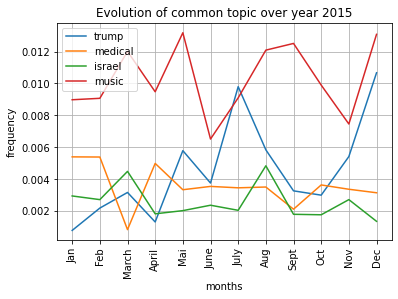

In [173]:
plt.figure()

for i,list_ in enumerate(lists_):
    count, _ ,num_quotes = topics_by_month_analysis(list_, nbr_of_topics, df_quotes, df_topics)

    plt.plot(range(1,13),np.array(count)/np.array(num_quotes),label=labels[i])


plt.ylabel("frequency")
plt.xlabel("months")
plt.xticks(range(1,13),["Jan","Feb","March","April","May","June","July","Aug","Sept","Oct","Nov","Dec"],rotation=90)
plt.grid()
plt.title(f"Evolution of common topic over year {year}")
plt.legend()

In [53]:
def plot_topic_over_year(list_,label,savepath,year_init=2015,year_end=2020):
    colors = ['b','k','r','y','m','g']
    plt.figure(figsize=(10,7))

    for i,color, year,df_quotes,df_topics in zip(range(0,len(colors)),colors,years,df_quotes_year,df_topics_year):
        if years[i] <= year_end and years[i]>=year_init:
            counts,titles,num_quotes = topics_by_month_analysis(list_,0,df_quotes,df_topics)
            plt.plot(range(1,13),np.array(counts)/np.array(num_quotes),f'{color}x-',label=f"{label}- {year}")


    plt.ylabel("frequency")
    plt.xlabel("months")
    plt.xticks(range(1,13),["Jan","Feb","March","April","May","June","July","Aug","Sept","Oct","Nov","Dec"],rotation=90)
    plt.grid()
    if year_init != year_end:
        plt.title(f"Evolution of quotes on {label} for the year {year_init} - {year_end}")
    else:
        plt.title(f"Evolution of quotes on {label} for the year {year_init}")

    plt.legend()
    plt.savefig(savepath)


#### 2.2.1 First topic of interest: Terrorism in 2015

2015 is infamous for the terrorism attack on Paris and therefore it will show in the frequency analysis of the topic over the month

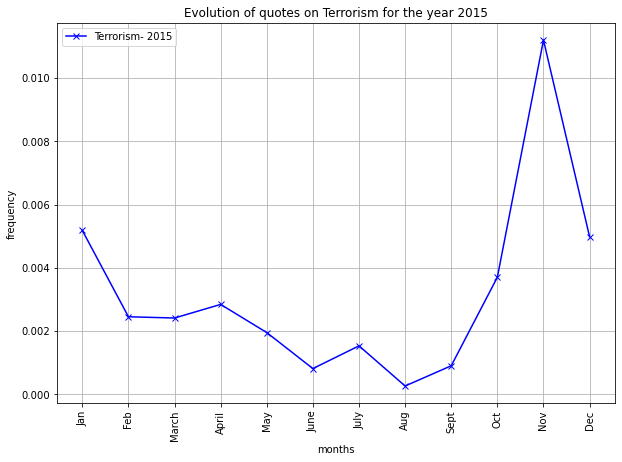

In [91]:
list_attack =["attack","terrorism","paris"]
plot_topic_over_year(list_attack,"Terrorism","results/figures/terrorism_2015.png",2015,2015)

#### 2.2.2 Second Topic of interest: Donald Trump over the years

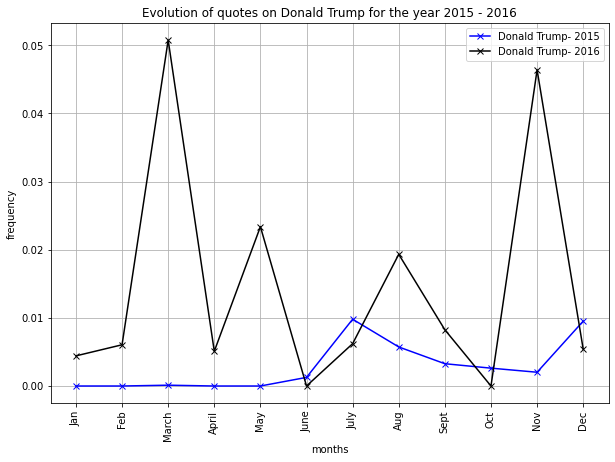

In [92]:
list_trump=["donald","trump"]
plot_topic_over_year(list_trump,"Donald Trump","results/figures/trump_2015-2020.png", 2015, 2016)

#### 2.2.3 Third Topic of interest: 

<ipython-input-90-e2794f4393bb>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(range(1,13),np.array(counts)/np.array(num_quotes),f'{color}x-',label=f"{label}- {year}")


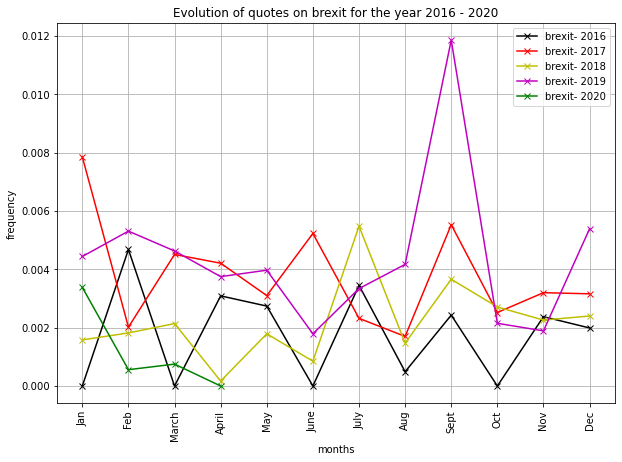

In [93]:
list_brexit=["brexit"]
plot_topic_over_year(list_brexit,"brexit","results/figures/brexit_2015-2020.png", 2016, 2020)

<ipython-input-90-e2794f4393bb>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(range(1,13),np.array(counts)/np.array(num_quotes),f'{color}x-',label=f"{label}- {year}")


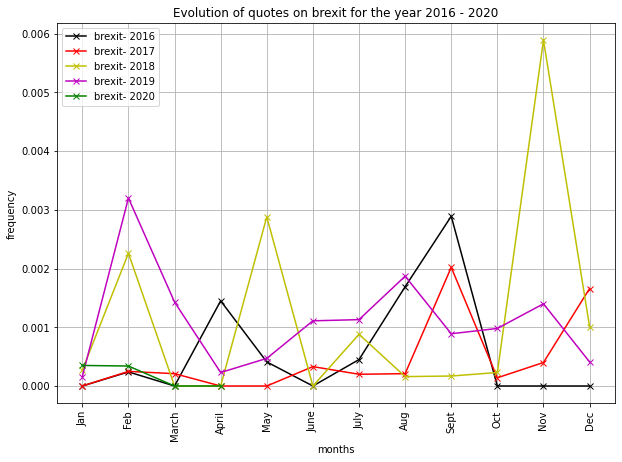

In [99]:
list_brexit=["hong","kong","hong-kong"]
plot_topic_over_year(list_brexit,"brexit","results/figures/hongkong_2015-2020.png", 2016, 2020)

### 2.3 Specific Topic Analysis  <a class="anchor" id="2-3"></a>

Until here we focused on general topics that we knew were going to be in the top topics. Here, we want to have a deeper focus on specific topic analysis which are related to specific event

#### 2.3.1 Proper Nouns Extraction

One way to detect specific topics in our analysis is to focus on proper nouns which are specific to a place or a person. When the person or place rises in terms of frequency then we can say that an event happened. In order to find out which event we can save the quotes. 

In [15]:
def extract_word_topics(df_topics_year):
    all_words = []
    for df_topics in df_topics_year:
        for row in df_topics.Words.values:
            if not(isinstance(row,type(True))):
                for word in row:
                    all_words.append(word[0])
        
    return all_words

all_words = extract_word_topics(df_topics_year)
print(all_words[0:10])

['half', 'defense', 'shots', 'game', 'points', 'win', 'played', 'second', 'ball', 'offense']


In [46]:
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk import edit_distance as dist

nouns_ = []
nouns_count = []

for i,word in enumerate(all_words[0:10000]):  
    # returns a document of object
    if not(isinstance(word,type(True))):
        eps = 1e-4
        if ((i/10000.)%0.1<eps):
            print(f"Processing {i/10000*100:.2f} %")

        doc = nlp(word)

        # checking if it is a noun or not
        if(doc[0].tag_ == 'NNP'):
            exists = False

            for i,noun in enumerate(nouns_):
                if dist(noun,word) < 2:
                    nouns_count[i]+=1
                    exists = True

            if not(exists):
                nouns_.append(word)
                nouns_count.append(1)      

Processing 0.00 %
Processing 10.00 %
Processing 10.01 %
Processing 20.00 %
Processing 20.01 %
Processing 30.01 %
Processing 40.00 %
Processing 40.01 %
Processing 50.01 %
Processing 60.01 %
Processing 70.01 %
Processing 80.00 %
Processing 80.01 %
Processing 90.01 %


In [51]:
indices = np.argsort(-np.array(nouns_count))

for word,count in zip(np.array(nouns_)[indices],np.array(nouns_count)[indices]):
    if count > 4:
        print("Word:",word,"| Count:",count) 

Word: nhl | Count: 10
Word: song | Count: 8
Word: gov | Count: 8
Word: fund | Count: 6
Word: kim | Count: 6
Word: russian | Count: 6
Word: uk | Count: 6
Word: india | Count: 6
Word: house | Count: 6
Word: american | Count: 6
Word: cup | Count: 6
Word: marry | Count: 6
Word: minister | Count: 6
Word: christ | Count: 5
Word: pakistan | Count: 5
Word: gay | Count: 5
Word: mr | Count: 5
Word: mas | Count: 5
Word: bank | Count: 5
Word: sad | Count: 5
Word: ang | Count: 5
Word: nigeria | Count: 5
Word: clinton | Count: 5
Word: cuba | Count: 5
Word: va | Count: 5
Word: ufc | Count: 5


To conclude, we can observe that many topics are about countries. This is not surprising because there are a lot of international events. But citing other countries in our analysis show that there probably had an important event such as terrorism attack.

**Example of nigeria:**

<ipython-input-53-e2794f4393bb>:8: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(range(1,13),np.array(counts)/np.array(num_quotes),f'{color}x-',label=f"{label}- {year}")


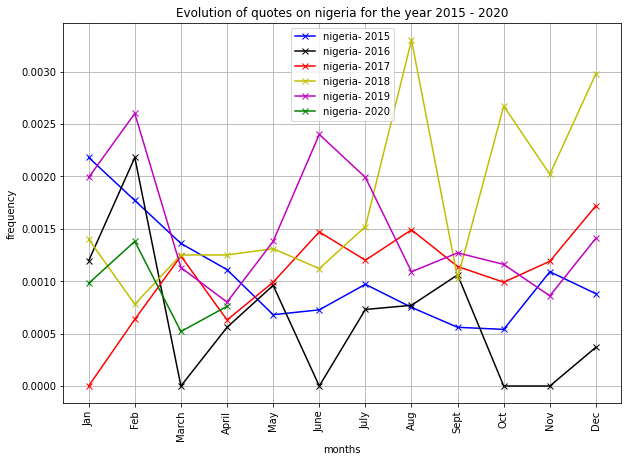

In [56]:
list_=["nigeria"]
plot_topic_over_year(list_,"nigeria","results/figures/nigeria_2015-2020.png", 2015, 2020)

In [66]:
quotes_nigeria = df_quotes_year[3][(df_quotes_year[3].date.dt.month==8) & (df_quotes_year[3].topic_number==5202)].sort_values(by=["topic_prob"],ascending=False).quotation.values

for quotes in quotes_nigeria[0:10]:
    print("----")
    print(quotes)

----
So we do hope they're paying attention.
----
There is no doubt that Nigeria is facing serious challenges which the leadership under President Muhammadu Buhari is pulling out all the stops to address. The APC administration means well for all Nigerian citizens
----
We also want to assure Tambuwal that his case will not be different from that of Ayo Fayose, as he will not only be rejected as the next governor of Sokoto state, but his presidential ambition will remain a pipe-dream as he has not only denied his people development but has wasted the scarce resources he ordinarily should have used to render service to the good people of Sokoto state. Definitely Tambuwal will go into political oblivion in 2019 as he is already running against the tide.
----
is indeed a testimony of Mr. President's integrity as his word is his bond.
----
We appeal that this commitment to protect citizens must be sustained especially at this time of the year when the military usually stage Operation Python

This allow us to learn about the events based only on the fact that Nigeria is a proper noun and that the quotes mention issues with the current president. It shows that our analysis works and can be semi-automated to detect international events

#### 2.3.2 Lemmatization

In [ ]:
# Common Word Extraction
from nltk.stem import LancasterStemmer

lancaster = LancasterStemmer()

# Format of the topic dataFrame
nbr_of_topics = 70

# Initialize useful Lists

# common words over year
year_words = []
year_count = []

all_words = []

# common words by month
month_words = []
month_words_lem = []
month_count = []
num_quotes = []
# Selection of a specific month
for j,month in enumerate(range(1,13)):
    
    print(f"Month {month}/12")
    num_quotes.append(len(df_quotes[df_quotes.date.dt.month==month]))
    hot_topics = df_topics[df_topics.Month==month].sort_values(by="Count",ascending=False)
    month_words_lem.append([])
    month_words.append([])
    month_count.append([])
    
    for words,counts in zip(hot_topics[1:nbr_of_topics].Words.values,hot_topics[1:nbr_of_topics].Count.values):
        
        if not(isinstance(words,type(True))):
            already_counted_month = []
            for word in words:
                    all_words.append(word[0])
                
                    word = word[0]

                    word_year = False     
                    
                    for i,year_word in enumerate(year_words):
                        if lancaster.stem(word) in year_word :
                            year_count[i]+=1
                            word_year = True
                            break

                    if not(word_year):  
                        year_words.append(lancaster.stem(word))
                        year_count.append(1)

                    word_month = False
                    for i,month_word in enumerate(month_words[j]):
                        if lancaster.stem(word) in month_word and not(i in already_counted):
                            month_count[j][i]+=counts
                            word_month = True
                            already_counted.append(i)

                            break

                    if not(word_month):
                        month_count[j].append(counts)
                        month_words_lem[j].append(lancaster.stem(word))
                        month_words[j].append(word)

print()
indices = np.argsort(-np.array(year_count))

for word,count in zip(np.array(year_words)[indices],np.array(year_count)[indices]):
    print("Word:",word,"| Count:",count)
    


**Here we have the opportunity to look at some interesting topics and their evolution over time**

First Topic of interest: Feminism, especially in 2017 with the Metoo movement

List = ["wom","fem","femin"]

In [53]:
import matplotlib.pyplot as plt

def mention_over_year(list_,month_words,month_count):
    sum_ = []
    for i,words,counts in zip(range(0,len(month_words)),month_words,month_count):
        sum_.append(0)
        for word, count in zip(words,counts):
            if word in list_:

                sum_[i]+=count
    return np.array(sum_)/np.array(num_quotes)
        

[100000, 100000, 100000, 100000, 100000, 94974, 100000, 100000, 100000, 100000, 100000, 100000]


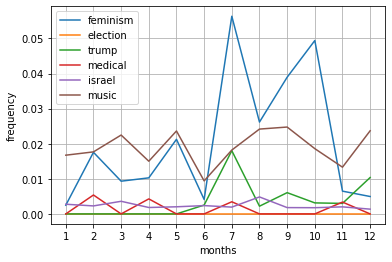

In [81]:
list_feminism = ["wom","fem","femin","she","girl"]
list_election = ["elect","presidentelect","vot"]
list_trump = ["trump","donald"]
list_medic = ["medicaid","medic","healthc","obamac"]
list_israel = ["israel","palestin"]
list_music  = ["mus","song","album","alb"]

lists_ = [list_feminism, list_election, list_trump, list_sport, list_israel, list_music]
label =["feminism","election","trump","medical","israel","music"]

plt.figure()

for i,list_ in enumerate(lists_):
    mention = mention_over_year(list_,month_words,month_count)
    plt.plot(range(1,13),mention,label=label[i])


plt.ylabel("frequency")
plt.xlabel("months")
plt.xticks(range(1,13))
plt.legend()
plt.grid()
print(num_quotes)

List of common Topic by Axelle: Sport, Education, Music, Justice (court),Transgenr, Feminism, Cinema, Medicare, racism, Kardashian, Terrorism, Muslim, Car race

Another interesting point in the quote topic is to look at the words associated to a topic and see which one are Proper nouns. Indeed, proper nouns will indicate 

### 2.4 Topics of Interest Extraction  <a class="anchor" id="2-4"></a>

## 3. Timeline Generation  <a class="anchor" id="3"></a>

### 3.1. Year 2015  <a class="anchor" id="3-1"></a>

In [ ]:
topics = ['Paris terrorist attack' , 'Greek presidential elections', 'Upcoming Game of Thrones season','H. Clinton candidacy','Same-sex marriage legal (U.S.)','Iran nuclear deal','Black Lives Matter' , 'Pope’s visit' , 'Canadian federal election' , 'Terrorist attack (France)' , 'Trump : border closing to Muslims']

months = [1 , 2,3,4,6,7,8,9,10,11,12]

counts = [270 , 217 , 273, 428 , 317,393 , 306 , 363, 350 ,417 , 471 ]

scaled_counts = (counts-np.min(counts))/(np.max(counts)-np.min(counts))

### plot part

x = np.linspace(1.5, 14.5, num=12)
y = 3*scaled_counts+0.9  # [from 0.9 to 3.75]

fig = plt.figure(figsize=(20,15),facecolor='white')
plt.box(False)
plt.axis('off')
electrode_pic = mpimg.imread('fleche4.png')
imgplot = plt.imshow(electrode_pic , extent = (-1.5, 22, -4,4))
plt.text(15.3, -0.1, 'Year 2015', fontfamily = 'cursive', fontsize = 18 )

for i in range (len(months)): 
    plt.plot([x[months[i]-1],x[months[i]-1]], [0,y[i]],'dimgrey')
    annot_txt = tw.fill(tw.dedent(topics[i].rstrip()), width=12)
    plt.annotate(annot_txt, xy=(1,2),xytext=(x[months[i]-1], y[i] + 0.1), ha = 'center', fontsize = 10)
    #plt.text(x[months[i]-1], y[i] + 0.1, topics[i], fontfamily = 'cursive' ,fontsize = 12, ha = 'center', wrap = True, bbox=dict(facecolor='none', edgecolor='none',boxstyle="Square"))

plt.title('Hot topics in 2015', fontfamily = 'cursive',fontsize = 18,  y=1.08, ha = 'right')
all_month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(12):
    plt.text(x[i]-0.2,-1.05, all_month[i], fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left')

# arrow 
plt.arrow(0, -0.1, 0, 4, width = 0.05, length_includes_head = True, shape = 'full', color = 'dimgrey')

plt.text(-0.3,2.7, 'Topic hotness', fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left', rotation ='vertical')

### 3.2. Year 2016

Text(-0.3, 2.7, 'Topic hotness')

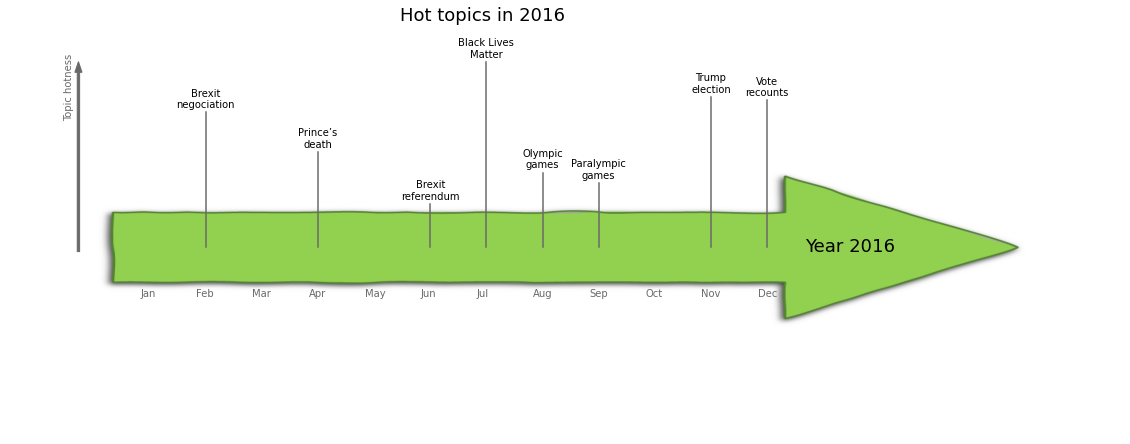

In [8]:
topics = ['Brexit negociation' , 'Prince’s death', 'Brexit referendum','Black Lives Matter','Olympic games','Paralympic games','Trump election' , 'Vote recounts']
months = [2 , 4, 6,7, 8,9,11, 12]

counts = [468 , 318 ,120 ,661, 240  , 201 , 527,514]
scaled_counts = (counts-np.min(counts))/(np.max(counts)-np.min(counts))

### plot part
x = np.linspace(1.5, 14.5, num=12)
y = 3*scaled_counts+0.9  # [from 0.9 to 3.75]

fig = plt.figure(figsize=(20,15),facecolor='white')
plt.box(False)
plt.axis('off')
electrode_pic = mpimg.imread('arrows_timeline/fleche2.png')
imgplot = plt.imshow(electrode_pic , extent = (-1.5, 22, -4,4))
plt.text(15.3, -0.1, 'Year 2016', fontfamily = 'cursive', fontsize = 18)

for i in range (len(months)): 
    plt.plot([x[months[i]-1],x[months[i]-1]], [0,y[i]],'dimgrey')
    annot_txt = tw.fill(tw.dedent(topics[i].rstrip()), width=12)
    plt.annotate(annot_txt, xy=(1,2),xytext=(x[months[i]-1], y[i] + 0.1), ha = 'center', fontsize = 10)
    #plt.text(x[months[i]-1], y[i] + 0.1, topics[i], fontfamily = 'cursive' ,fontsize = 12, ha = 'center', wrap = True, bbox=dict(facecolor='none', edgecolor='none',boxstyle="Square"))

plt.title('Hot topics in 2016', fontfamily = 'cursive',fontsize = 18,  y=1.08, ha = 'right')
all_month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(12):
    plt.text(x[i]-0.2,-1.05, all_month[i], fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left')

# arrow 
plt.arrow(0, -0.1, 0, 4, width = 0.05, length_includes_head = True, shape = 'full', color = 'dimgrey')

plt.text(-0.3,2.7, 'Topic hotness' ,fontsize = 10, color = 'dimgrey', ha = 'left', rotation ='vertical')

### 3.3. Year 2017

Text(-0.3, 2.7, 'Topic hotness')

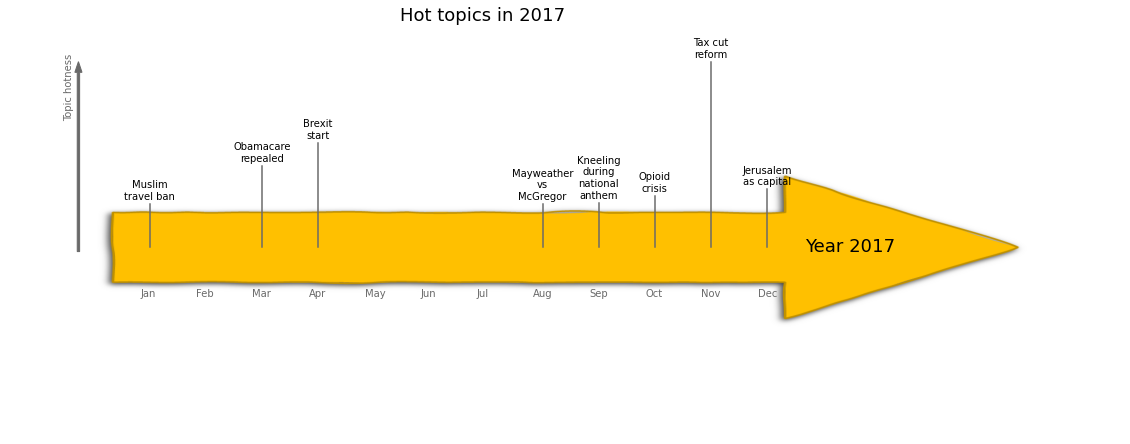

In [14]:
topics = ['Muslim travel ban' , 'Obamacare repealed', 'Brexit start','Mayweather vs McGregor','Kneeling during national anthem','Opioid crisis','Tax cut reform' , 'Jerusalem as capital']
months = [1 , 3, 4, 8,9,10,11,12]
indexes = [7 , 379, 1109 , 4099, 4927,5727,6614,7402]

### plot part

x = np.linspace(1.5, 14.5, num=12)
y = 3*scaled_counts+0.9  # [from 0.9 to 3.75]

fig = plt.figure(figsize=(20,15),facecolor='white')
plt.box(False)
plt.axis('off')
electrode_pic = mpimg.imread('arrows_timeline/fleche_timeline.png')
imgplot = plt.imshow(electrode_pic , extent = (-1.5, 22, -4,4))
plt.text(15.3, -0.1, 'Year 2017', fontfamily = 'cursive', fontsize = 18 )

for i in range (len(indexes)): 
  plt.plot([x[months[i]-1],x[months[i]-1]], [0,y[i]],'dimgrey')
  annot_txt = tw.fill(tw.dedent(topics[i].rstrip()), width=10)
  plt.annotate(annot_txt, xy=(1,2),xytext=(x[months[i]-1], y[i] + 0.1), ha = 'center', fontsize = 10)
  #plt.text(x[months[i]-1], y[i] + 0.1, topics[i], fontfamily = 'cursive' ,fontsize = 12, ha = 'center', wrap = True, bbox=dict(facecolor='none', edgecolor='none',boxstyle="Square"))

plt.title('Hot topics in 2017', fontfamily = 'cursive',fontsize = 18,  y=1.08, ha = 'right')
all_month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(12):
  plt.text(x[i]-0.2,-1.05, all_month[i], fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left')

# arrow 
plt.arrow(0, -0.1, 0, 4, width = 0.05, length_includes_head = True, shape = 'full', color = 'dimgrey')

plt.text(-0.3,2.7, 'Topic hotness', fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left', rotation ='vertical')

### 3.4. Year 2018

### 3.5. Year 2019

Text(-0.3, 2.7, 'Topic hotness')

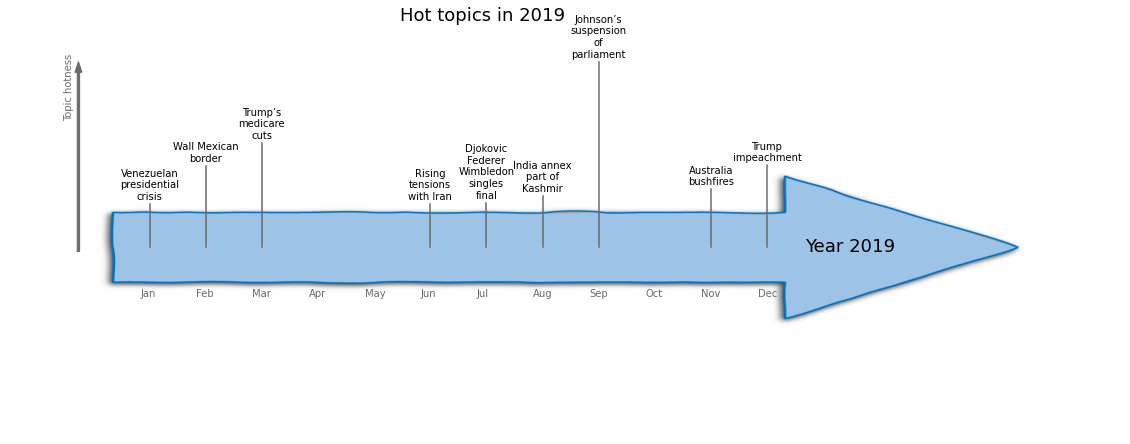

In [12]:
topics = ['Venezuelan presidential crisis' , 'Wall Mexican border', 'Trump’s medicare cuts','Rising tensions with Iran','Djokovic Federer Wimbledon singles final','India annex part of Kashmir ','Johnson’s suspension of parliament' , 'Australia bushfires' , 'Trump impeachment']
months = [1,2,3,6,7,8,9,11,12]

counts = [245 ,  478, 616 , 244 , 253, 295 , 1113, 335 ,480 ]
scaled_counts = (counts-np.min(counts))/(np.max(counts)-np.min(counts))

### plot part

x = np.linspace(1.5, 14.5, num=12)
y = 3*scaled_counts+0.9  # [from 0.9 to 3.75]

fig = plt.figure(figsize=(20,15),facecolor='white')
plt.box(False)
plt.axis('off')
electrode_pic = mpimg.imread('arrows_timeline/fleche3.png')
imgplot = plt.imshow(electrode_pic , extent = (-1.5, 22, -4,4))
plt.text(15.3, -0.1, 'Year 2019', fontfamily = 'cursive', fontsize = 18 )

for i in range (len(months)): 
  plt.plot([x[months[i]-1],x[months[i]-1]], [0,y[i]],'dimgrey')
  annot_txt = tw.fill(tw.dedent(topics[i].rstrip()), width=12)
  plt.annotate(annot_txt, xy=(1,2),xytext=(x[months[i]-1], y[i] + 0.1), ha = 'center', fontsize = 10)
  #plt.text(x[months[i]-1], y[i] + 0.1, topics[i], fontfamily = 'cursive' ,fontsize = 12, ha = 'center', wrap = True, bbox=dict(facecolor='none', edgecolor='none',boxstyle="Square"))

plt.title('Hot topics in 2019', fontfamily = 'cursive',fontsize = 18,  y=1.08, ha = 'right')
all_month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i in range(12):
  plt.text(x[i]-0.2,-1.05, all_month[i], fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left')

# arrow 
plt.arrow(0, -0.1, 0, 4, width = 0.05, length_includes_head = True, shape = 'full', color = 'dimgrey')

plt.text(-0.3,2.7, 'Topic hotness', fontfamily = 'cursive' ,fontsize = 10, color = 'dimgrey', ha = 'left', rotation ='vertical')

### 3.6 Year 2020

## 4. Sentiment Analysis  <a class="anchor" id="4"></a>